In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from data.motion_dataset import MotionDataset
from data.motion_sampler import MotionSampler
from data.utils import collate_fn_motion

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.9.1+cu128
12.8
True


In [4]:
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_dataset = MotionDataset('train', tokenizer_name='t5-small')
train_sampler = MotionSampler(train_dataset.motion_frames, batch_size=16, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler, collate_fn=collate_fn_motion, num_workers=0)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [7]:
from models.transformers.transfoLM import TransfoLM
from torchinfo import summary

tflm = TransfoLM(motion_dim=66, lm_name='t5-small', max_seq_len=300)
# summary(tflm, input_size=((16, 62, 22, 3), (16, 100)))  # (batch_size, seq_len, n_joints, 3), (batch_size, text_seq_len)

cuda
True


Training Progress: 100%|██████████| 6/6 [52:52<00:00, 528.67s/it, train_loss=0.103]


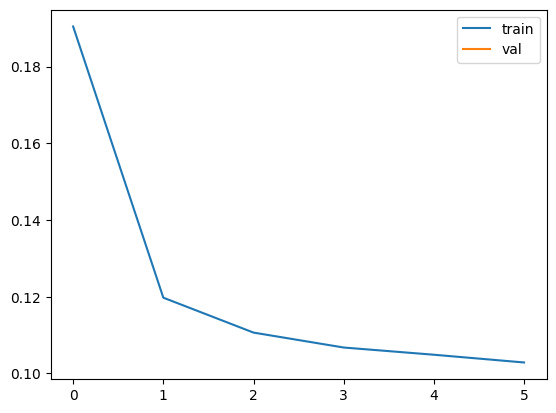

In [ ]:
from models.transformers.methods import training

print(device)
print(torch.cuda.is_available())

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, tflm.parameters()), lr=1e-4)

train_losses, val_losses = training(
    model=tflm,
    train_loader=train_dataloader,
    val_loader=None,
    epochs=6,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer,
    device=device
)

torch.save(tflm.state_dict(), '/models/saved/tflm.pt')

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


In [ ]:
print(train_losses, val_losses)

[0.19046990198200792, 0.11973976807779048, 0.1106340000396349, 0.10674115087106707, 0.10485981299923915, 0.10284024770134245] []


In [18]:
from torch.amp import autocast, GradScaler

val_dataset = MotionDataset('val')
val_sampler = MotionSampler(val_dataset.motion_frames, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, collate_fn=collate_fn_motion, shuffle=False)

test_dataset = MotionDataset('test')
test_sampler = MotionSampler(test_dataset.motion_frames, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler, collate_fn=collate_fn_motion, shuffle=False)

tflm.load_state_dict(torch.load('./models/saved/tflm.pt', weights_only=True, map_location=device))
tflm.to(device)

TransfoLM(
  (enc_embedding): Linear(in_features=66, out_features=512, bias=True)
  (pos_embedding): PositionalEmbedding()
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (s_atten): MultiHeadAttention(
        (query): Linear(in_features=512, out_features=512, bias=True)
        (key): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (output): Linear(in_features=512, out_features=512, bias=True)
      )
      (layer_1_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (feed_fwrd): FeedForward(
        (linear_1): Linear(in_features=512, out_features=2048, bias=True)
        (relu): ReLU()
        (linear_2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (layer_2_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (lm): T5ForConditionalGeneration(
    (shared): Embedding(32128, 512)
    (encoder

In [20]:
from models.transformers.methods import evaluation

val_loss, val_accuracy = evaluation(
    model=tflm,
    data_loader=val_loader,
    device=device
)

print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
plt.plot(val_loss, label='val_loss')
plt.plot(val_accuracy, label='val_accuracy')
plt.legend()
plt.show()

ImportError: cannot import name 'evaluation' from 'models.transformers.methods' (/home/aki/human-motion/Human-Motion/models/transformers/methods.py)